In [45]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule, ImputationDataset
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.ops.imputation import add_missing_values
from tsl.engines import Imputer
from tsl.transforms import MaskInput
from tsl.nn.models import GRINModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
from tsl.metrics import torch as torch_metrics
import matplotlib.pyplot as plt
import torch


In [46]:
p_fault, p_noise = 0., 0.25
dataset = AirQuality(impute_nans=True, small=True)
 
    
adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = ImputationDataset(target=dataset.dataframe()[-5000:],
                                    mask=dataset.training_mask[-5000:],
                                    eval_mask=dataset.eval_mask[-5000:],
                                    covariates=None,
                                    transform=MaskInput(),
                                    connectivity=adj,
                                    window=1,
                                    stride=1)


scalers = {'target': StandardScaler(axis=(0, 1))}
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.2, 'test_len': 0.1}),
    batch_size=1,
    workers=8)
dm.setup(stage='test')
dm.trainset = list(range(len(torch_dataset)))

In [47]:
loss_fn = torch_metrics.MaskedMAE()
loss_fn2 = torch_metrics.MaskedMRE()
loss_fn3 = torch_metrics.MaskedMSE()

# setup generator
imputer = Imputer.load_from_checkpoint('/storagenfs/p.magos/TSGen/logs/prediction/best-model-epoch=26-val_loss=0.6421.ckpt')

In [48]:
trainer = Trainer()

imputer.freeze()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [49]:
output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
output = imputer.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true, mask = (output['y_hat'], output['y'], output['mask'])
y_hat = torch.tensor(y_hat)
y_true = torch.tensor(y_true)
mask = torch.tensor(mask)
res = dict(test_mae=loss_fn(y_hat, y_true, mask=mask), test_mre=loss_fn2(y_hat, y_true, mask=mask), test_mse=loss_fn3(y_hat, y_true, mask=mask))
res

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0:   0%|          | 0/1488 [00:00<?, ?it/s]

Only args ['edge_index', 'edge_weight', 'x', 'mask'] are forwarded to the model (GRINModel).


Predicting DataLoader 0: 100%|██████████| 1488/1488 [00:23<00:00, 62.11it/s]


{'test_mae': tensor(19.7187),
 'test_mre': tensor(0.2340),
 'test_mse': tensor(1079.6418)}

In [110]:
input = y_true[-500:]
mask_ = mask[-500:]
# mask_ = torch.cat([mask_[-200:-100], torch.zeros(mask[-100:].size(), dtype=torch.bool)])
prediction = imputer.predict(input, torch.tensor(adj[0]), torch.tensor(adj[1]), mask_)

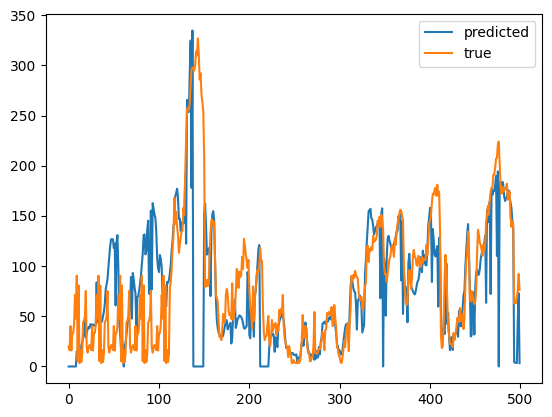

In [111]:
plt.plot(prediction[:, 0, 0], label='predicted')
plt.plot(input[:, 0, 0], label='true')
plt.legend()
plt.show()

In [112]:
prediction = prediction.reshape(prediction.shape[0], prediction.shape[-2])

In [113]:
import pandas as pd

cols = dataset.dataframe().columns.droplevel('channels')
df = pd.DataFrame(prediction, columns=cols)

In [114]:
df

nodes,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036
0,-0.368697,-0.480303,-0.364930,-0.317566,-0.184586,-0.393997,-0.395891,-0.358596,-0.379212,-0.199433,...,-0.468977,-0.501789,-0.620431,-0.557164,-0.595430,-0.595093,-0.317683,0.042109,0.072043,0.313402
1,-0.368697,-0.480303,-0.364930,-0.317566,-0.184586,-0.393997,-0.395891,-0.358596,-0.379212,-0.199433,...,-0.468977,-0.501789,-0.620431,-0.557164,-0.595430,-0.595093,-0.317683,0.042109,0.072043,0.313402
2,-0.368697,-0.480303,-0.364930,-0.317566,-0.184586,-0.393997,-0.395891,-0.358596,-0.379212,-0.199433,...,-0.468977,-0.501789,-0.620431,-0.557164,-0.595430,-0.595093,-0.317683,0.042109,0.072043,0.313402
3,-0.368697,-0.480303,-0.364930,-0.317566,-0.184586,-0.393997,-0.395891,-0.358596,-0.379212,-0.199433,...,-0.468977,-0.501789,-0.620431,-0.557164,-0.595430,-0.595093,-0.317683,0.042109,0.072043,0.313402
4,-0.368697,-0.480303,-0.364930,-0.317566,-0.184586,-0.393997,-0.395891,-0.358596,-0.379212,-0.199433,...,-0.468977,-0.501789,-0.620431,-0.557164,-0.595430,-0.595093,-0.317683,0.042109,0.072043,0.313402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3.280110,3.669251,3.686767,3.509814,3.085662,4.477374,5.367239,5.161355,5.077698,5.590153,...,-0.468977,-0.501789,-0.620431,-0.557164,-0.595430,-0.595093,-0.317683,6.363572,0.072043,0.313402
496,3.036802,3.374395,3.402929,3.257601,2.885847,4.120381,4.924136,4.755137,4.677674,5.163941,...,-0.468977,-0.501789,-0.620431,-0.557164,-0.595430,-0.595093,-0.317683,5.867002,0.072043,0.313402
497,45.088894,38.371403,27.491907,28.389462,24.299763,34.369751,35.703606,37.957420,30.577572,34.706902,...,43.361526,38.960476,44.433762,44.495445,53.306057,24.060661,6.982396,18.492804,4.304778,6.509279
498,72.838585,76.587822,69.372826,69.291756,70.499954,71.366096,71.857521,71.095619,70.980942,70.977112,...,87.843048,82.985634,126.217995,98.926109,119.007011,85.487274,79.520660,74.213600,70.321358,67.985565


In [115]:
df.to_csv('GRINAirQualityImputation.csv', index=False)